# Preparing the data for discrete set case 1

Load main libraries, set paths and adjust plotting theme (optional)

In [1]:
from pathlib import Path
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')
pv.global_theme.background = 'white'
pv.global_theme.color = "beige"
pv.global_theme.show_edges = True
pv.global_theme.window_size = [800, 400]

STATICS_DIR = Path("../../../../_static")
HEXBEAM_FILEPATH = STATICS_DIR / "hexbeam.vtk"

### Load the Mesh

In this examples, we are simply interested in manipulating the FEB file and not the mesh itself, therefore we will be used pre-defined mesh.
If you wish to create the mesh using python, we recommend using the pyvista or the gmsh and pygmsh libraries. 

Number of nodes: 1331
Number of cells: 1000


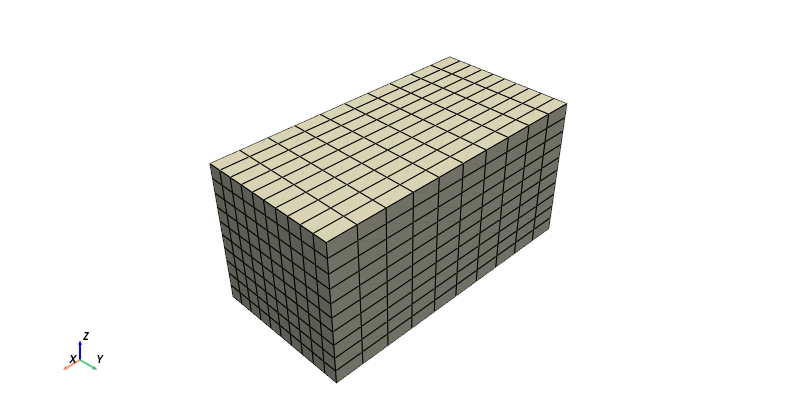

In [2]:
# Load the mesh
grid = pv.read(HEXBEAM_FILEPATH)
print(f"Number of nodes: {grid.n_points}")
print(f"Number of cells: {grid.n_cells}")
grid.plot(color="beige")

### Setup the blocks positions

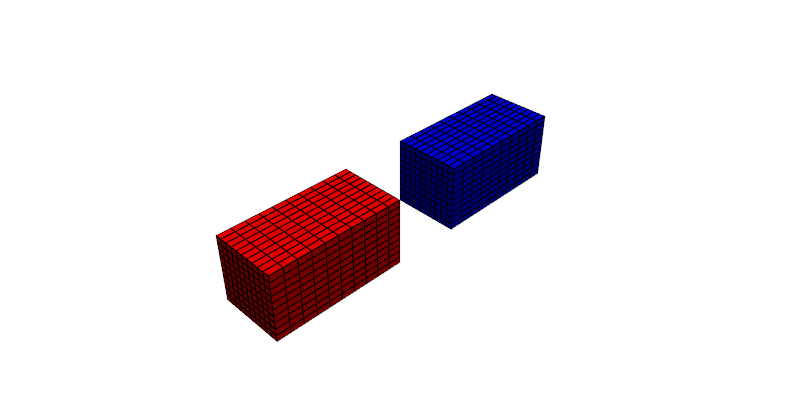

In [3]:
first_block = grid.copy()
second_block = grid.copy()

first_block.points[:, 0] += 1.5
second_block.points[:, 0] -= 1.5

plotter = pv.Plotter()
plotter.add_mesh(first_block, color="red")
plotter.add_mesh(second_block, color="blue")
plotter.show()

### Prepare the data (find node ids of interest)

#### Find the discrete sets

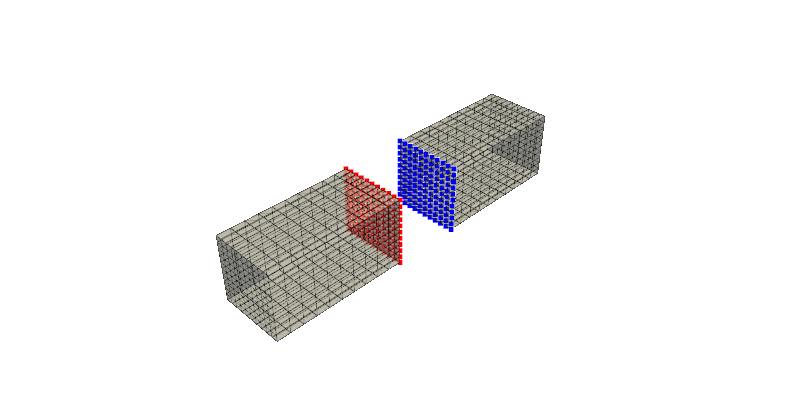

In [4]:
# For the first block, find the "x-min" nodes
first_block_nodes = first_block.points
first_block_xmin = np.min(first_block_nodes[:, 0])
first_block_discrete_ids = np.where(abs(first_block_nodes[:, 0] - first_block_xmin) <= 1e-6)[0]

# For the second block, find the "x-max" nodes
second_block_nodes = second_block.points
second_block_xmax = np.max(second_block_nodes[:, 0])
second_block_discrete_ids = np.where(abs(second_block_nodes[:, 0] - second_block_xmax) <= 1e-6)[0]

# Select the nodes (we will be using them later on)
first_block_selected_nodes = first_block_nodes[first_block_discrete_ids]
second_block_selected_nodes = second_block_nodes[second_block_discrete_ids]

# For visualization, we will plot the nodes that we found:
plotter = pv.Plotter()
plotter.add_mesh(first_block, color="beige", opacity=0.5)
plotter.add_mesh(second_block, color="beige", opacity=0.5)
plotter.add_points(first_block_selected_nodes, color="red", point_size=5)
plotter.add_points(second_block_selected_nodes, color="blue", point_size=5)
plotter.show()

In [5]:
from scipy.spatial.distance import cdist

first_block_selected_nodes = first_block_nodes[first_block_discrete_ids]
second_block_selected_nodes = second_block_nodes[second_block_discrete_ids]

# compute the distance matrix
dist_matrix = cdist(first_block_selected_nodes, second_block_selected_nodes)
# get the indices of the minimum distances for each node
min_indices = np.argmin(dist_matrix, axis=1)
# create the discrete set, which is a numpy array of shape (n, 2)
discrete_set_indices = np.column_stack((first_block_discrete_ids, min_indices))

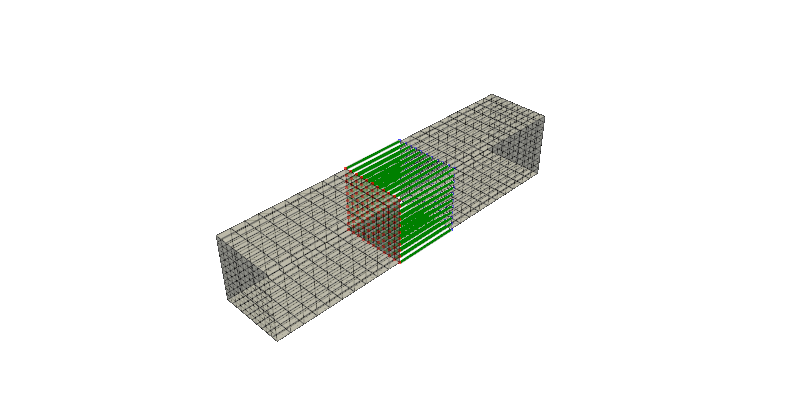

In [6]:
src_points = first_block_selected_nodes[discrete_set_indices[:, 0]]
dst_points = second_block_selected_nodes[discrete_set_indices[:, 1]]
lines = np.stack((src_points, dst_points), axis=1).reshape(-1, 3)

plotter = pv.Plotter()
plotter.add_mesh(first_block, color="beige", opacity=0.5)
plotter.add_mesh(second_block, color="beige", opacity=0.5)
plotter.add_points(first_block_nodes[first_block_discrete_ids], color="red", point_size=3, opacity=0.7)
plotter.add_points(second_block_nodes[second_block_discrete_ids], color="blue", point_size=3, opacity=0.7)
plotter.add_lines(lines, color="green", width=3)
plotter.show()

#### Find node ids for boundary conditions

In [7]:
# For the second block, find the "x-min" nodes
second_block_nodes = second_block.points
second_block_xmin = np.min(second_block_nodes[:, 0])
second_block_boundary_ids = np.where(abs(second_block_nodes[:, 0] - second_block_xmin) <= 1e-6)[0]

# we will also apply boundary conditions to the "ground" nodes
min_z = np.min(second_block_nodes[:, 2])
second_block_ground_ids = np.where(abs(second_block_nodes[:, 2] - min_z) <= 1e-6)[0]
first_block_ground_ids = np.where(abs(first_block_nodes[:, 2] - min_z) <= 1e-6)[0]

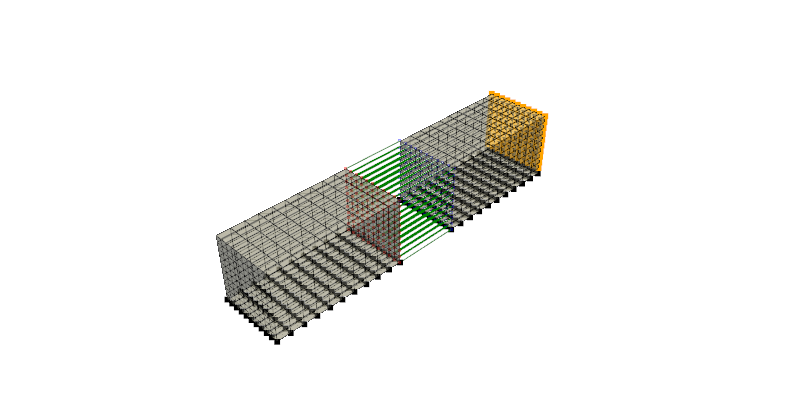

In [8]:
plotter = pv.Plotter()
plotter.add_mesh(first_block, color="beige", opacity=0.5)
plotter.add_mesh(second_block, color="beige", opacity=0.5)
plotter.add_points(first_block_nodes[first_block_discrete_ids], color="red", point_size=3, opacity=0.4)
plotter.add_points(second_block_nodes[second_block_discrete_ids], color="blue", point_size=3, opacity=0.4)
plotter.add_lines(lines, color="green", width=1)
plotter.add_points(second_block_nodes[second_block_boundary_ids], color="orange", point_size=6)
plotter.add_points(second_block_nodes[second_block_ground_ids], color="black", point_size=6)
plotter.add_points(first_block_nodes[first_block_ground_ids], color="black", point_size=6)
plotter.show()

### Create surface to apply surface load

In [9]:
# First, extract the surface of the first block
first_block_surface = first_block.extract_surface()
# Make sure it is a unsructured grid
first_block_surface = first_block_surface.cast_to_unstructured_grid()
# Compute cell centers
centers = first_block_surface.cell_centers()
# find the "x-max" cell centers
center_xmax = np.max(centers.points[:, 0])
first_block_surface_load_ids = np.where(abs(centers.points[:, 0] - center_xmax) <= 1e-6)[0]
selected_load_surface = first_block_surface.copy().extract_cells(first_block_surface_load_ids)
selected_load_surface = selected_load_surface.cast_to_unstructured_grid()

# we now need to map the node indices to the first original block
first_map = selected_load_surface["vtkOriginalPointIds"]  # from selected surface to extracted surface
second_map = first_block_surface["vtkOriginalPointIds"]   # from extracted surface to original block mesh

load_surface_connectivity = selected_load_surface.cells_dict[pv.CellType.QUAD]

for i, cell in enumerate(load_surface_connectivity):
    cell = [first_map[j] for j in cell]
    load_surface_connectivity[i] = [second_map[j] for j in cell]

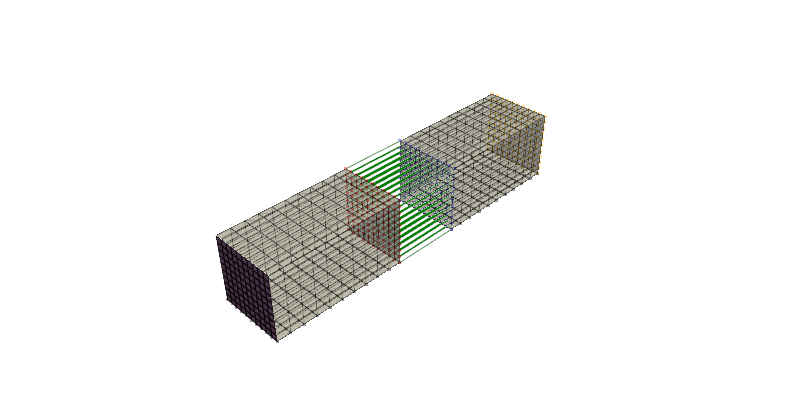

In [10]:
plotter = pv.Plotter()
plotter.add_mesh(first_block, color="beige", opacity=0.5)
plotter.add_mesh(second_block, color="beige", opacity=0.5)
plotter.add_points(first_block_nodes[first_block_discrete_ids], color="red", point_size=3, opacity=0.4)
plotter.add_points(second_block_nodes[second_block_discrete_ids], color="blue", point_size=3, opacity=0.4)
plotter.add_lines(lines, color="green", width=1)
plotter.add_points(second_block_nodes[second_block_boundary_ids], color="orange", point_size=3, opacity=0.4)
plotter.add_points(second_block_nodes[second_block_ground_ids], color="black", point_size=3, opacity=0.4)
plotter.add_points(first_block_nodes[first_block_ground_ids], color="black", point_size=3, opacity=0.4)
plotter.add_mesh(selected_load_surface, color="purple", point_size=6)
plotter.show()

### Saving as a multiblock

In [11]:
# Assign the discrete ids as field data
first_block.field_data["discrete_ids"] = first_block_discrete_ids
second_block.field_data["discrete_ids"] = second_block_discrete_ids

# Add boundary and ground ids as field data
first_block.field_data["ground_ids"] = first_block_ground_ids
second_block.field_data["boundary_ids"] = second_block_boundary_ids
second_block.field_data["ground_ids"] = second_block_ground_ids

# Add the load surface connectivity as field data
selected_load_surface.field_data["load_surface_connectivity"] = load_surface_connectivity

In [12]:
mb = pv.MultiBlock(
    {
        "first_block": first_block,
        "second_block": second_block,
        "selected_load_surface": selected_load_surface
    }
)

In [13]:
mb.save(STATICS_DIR / "hexbeam_multiblock_discrete_case_1.vtm")